<a href="https://colab.research.google.com/github/Hyun3246/Code-Warehouse/blob/main/Predict_California_Housing_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 준비

In [1]:
# 데이터 다운로드
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as tarball:
            tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


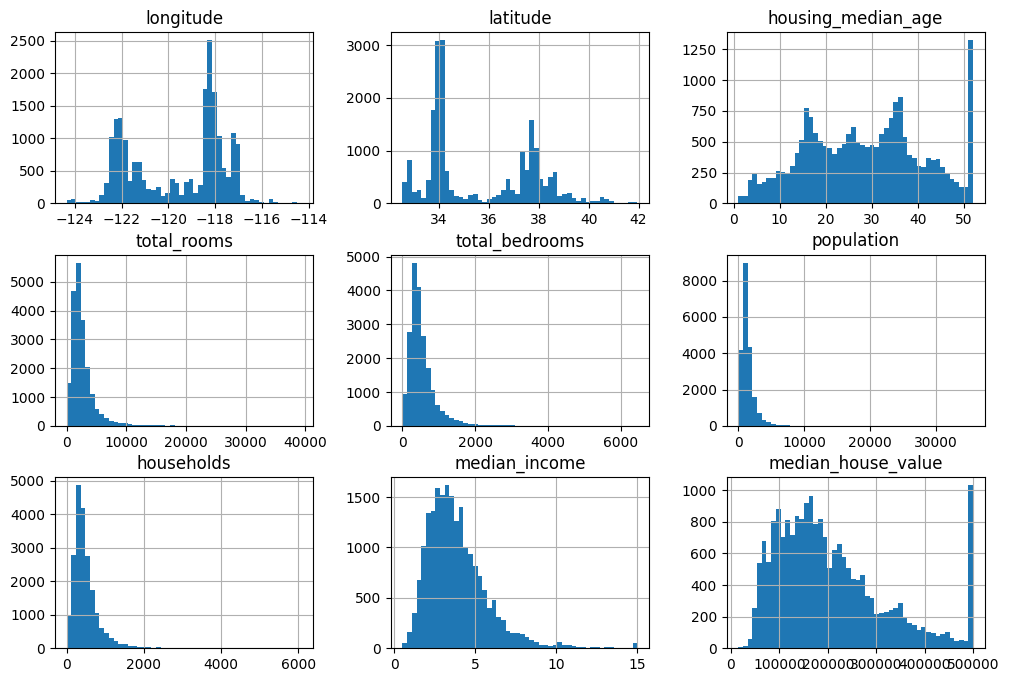

In [6]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [7]:
# test set 분리
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [9]:
len(train_set), len(test_set)

(16512, 4128)

In [10]:
# 다시 훈련하더라도 이전에 test set에 있던 데이터를 train set에 포함시키지 않아야 한다. (해시값 이용)
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()     # index 열이 추가된 데이터 프레임 반환
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'index')

In [12]:
# 위도와 경도는 변치 않으니까 조합해서 ID로 쓰자.
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'id')

In [13]:
# 난수 초깃값을 지정할 수도 있다.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [14]:
# 중간 소득은 카테고리로 변경 (계층적 샘플링)
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [15]:
# matplotlib에서 한글 쓰기
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 23.7 MB/s eta 0:00:00


In [16]:
# matplotlib에서 한글 쓰기
import koreanize_matplotlib

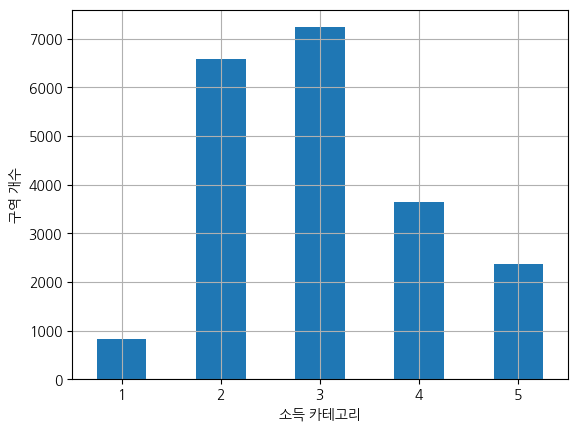

In [17]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("소득 카테고리")
plt.ylabel("구역 개수")
plt.show()

In [18]:
# 하나의 데이터셋으로 각기 다른 10개의 계층 분할 생성
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [19]:
strat_train_set, strat_test_set = strat_splits[0]

In [20]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [21]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [22]:
# income_cat을 사용하지 않을 예정이므로 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## 데이터 이해를 위한 탐색과 시각화

In [23]:
# 복사본 만들기
housing = strat_train_set.copy()

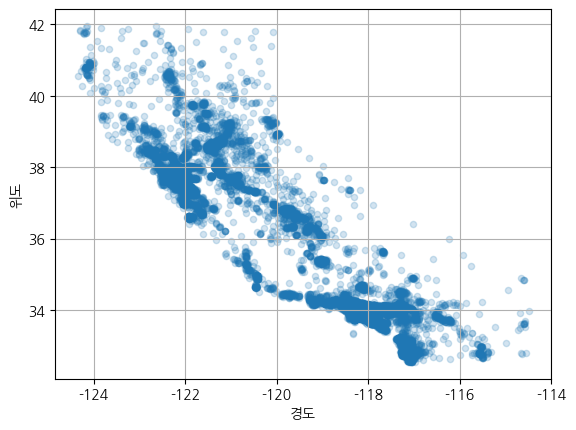

In [24]:
# 산점도
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.2)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

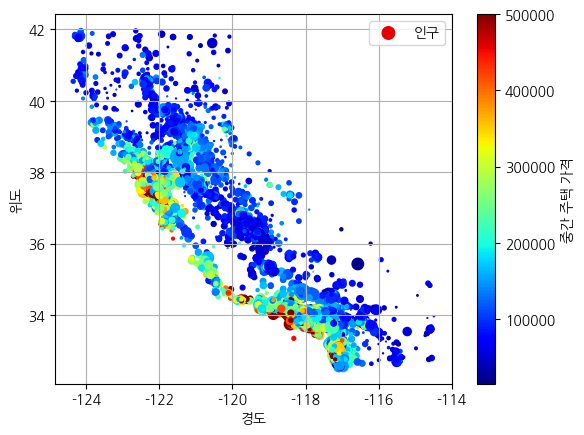

In [25]:
# 주택 가격 나타내기. 원의 반지름(s)은 인구, 색상(c)은 가격.
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
             s=housing['population']/100, label='인구',
             c='median_house_value', cmap='jet', colorbar=True)
cax=plt.gcf().get_axes()[1]
cax.set_ylabel("중간 주택 가격")
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

In [26]:
# 표준 상관계수 사용
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


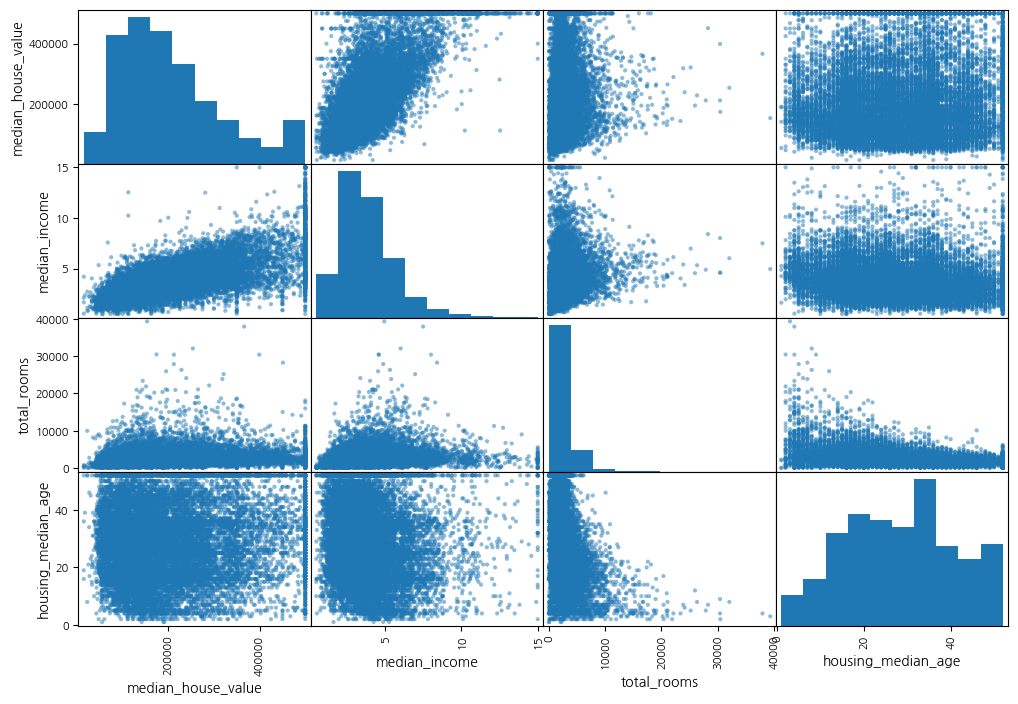

In [27]:
# 상관관계 산점도로 그리기
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

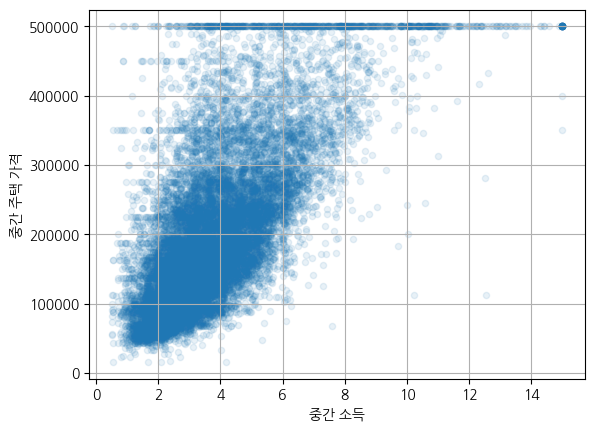

In [28]:
# 중간 소득이 가장 유용해 보이므로 산점도 확대
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
plt.xlabel("중간 소득")
plt.ylabel("중간 주택 가격")
plt.show()

In [29]:
# 특성 공학: 더 유용한 특성 만들기
housing['room_per_house'] = housing['total_rooms'] / housing['households']      # 가구당 방 개수
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']      # 전체 방에서 침실의 비율
housing['population_per_house'] = housing['population'] / housing['households']      # 가구당 인구

In [30]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
room_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
population_per_house,-0.038224
longitude,-0.050859


## 데이터 전처리

In [32]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [33]:
# null 값 제거하기
# housing.dropna(subset=['total_bedrooms'], inplace=True)     # 값이 없는 데이터 제거
# housing.drop("total_bedrooms", axis=1, inplace=True)        # 특성 삭제

median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)      # 중간값으로 채우기

<ipython-input-33-ac0e7184922e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['total_bedrooms'].fillna(median, inplace=True)      # 중간값으로 채우기


In [34]:
# 중간값으로 채우기의 다른 방법
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [35]:
housing_num = housing.select_dtypes(include=[np.number])        # 수치 특성만 가진 데이터 복사본 생성

In [36]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
# 모든 특성에 imputer를 적용해야 나중에 생길 문제를 예방할 수 있다.
imputer.statistics_
housing_num.median().values
X = imputer.transform(housing_num)

In [40]:
# 넘파이 출력을 데이터 프레임으로 변환
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [41]:
# 범주형 특성 다루기
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [42]:
# 카테고리를 텍스트로 변환
from sklearn.preprocessing import OrdinalEncoder

oridinal_encoder = OrdinalEncoder()
housing_cat_encoded = oridinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [43]:
oridinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
# 원-핫 인코딩
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
# 희소 행렬을 넘파이 배열로
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [48]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [51]:
# 판다스의 get_dummies
df_test = pd.DataFrame({"ocean_proximity": ['INLAND', 'NEAR BAY']})
pd.get_dummies(df_test, dtype='int')

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [52]:
cat_encoder.transform(df_test)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [54]:
df_test_unknown = pd.DataFrame({'ocean_proximity': ['<2H OCEAN', 'ISLAND']})
pd.get_dummies(df_test_unknown, dtype='int')

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [55]:
# OneHotEncoder는 알 수 없는 카테고리를 감지하고 예외 발생
cat_encoder.handle_unknown = 'ignore'
cat_encoder.transform(df_test_unknown)

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [57]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [58]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [59]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [60]:
# 특성 스케일링 (Min-Max)
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [61]:
# 특성 스케일링 (표준화)
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [62]:
# 멀티모달 분포를 변환하기 위해 방사기저함수(RBF) 특성 생성
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [64]:
# 타깃값을 스케일링하고 다시 되돌리는 예시(지금까지 해온 과정과 무관한 코드)
from sklearn.linear_model import LinearRegression
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5]     # 새로운 데이터라고 가정
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

# 다른 방법
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

In [65]:
# 특성 분포의 꼬리가 두꺼울 때는 로그 변환
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

In [66]:
# 가우스 RBF 유사도 계산 변환기
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

In [67]:
# 각 구역과 샌프란시스코 사이의 지리적 유사도를 측정하는 특성 추가
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

In [68]:
# 특성 합치기 - 첫 번째와 두 번째 특성 사이의 비율 계산
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [69]:
# StandardScaler와 비슷하게 작동하는 사용자 정의 변환기
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [70]:
# Kmeans 사용자 변환기
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f'클러스터 {i} 유사도' for i in range(self.n_clusters)]

In [71]:
# 위 사용자 정의 변환기를 사용해보자.
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

In [72]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

In [75]:
# 변환 파이프라인
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [77]:
# 각 변환기의 이름 짓는 것이 귀찮을 때
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [79]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [81]:
# 각 열마다 적절한 변환을 적용하여 모든 열 처리
from sklearn.compose import ColumnTransformer
num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [82]:
# 특성의 이름을 일일이 나열하는 것은 번거롭다. & 변환기 이름을 짓는 것이 귀찮다.
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [83]:
# 데이터셋에 적용
housing_prepared = preprocessing.fit_transform(housing)

In [85]:
# 지금까지 수행한 모든 과정을 담은 단일 파이프라인
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('room_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
],
                                  remainder=default_num_pipeline)

In [86]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [87]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'room_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)